In [1]:
from matplotlib import pyplot as plt
from matplotlib import animation

import networkx as nx
import numpy as np
import numpy.ma as ma
import pandas as pd

In [291]:
UP = "UP"
DOWN = "DOWN"

class Trial:
    def __init__(
        self,
        A, # adjacency matrix
        N,
        M,
        n_trials,
        memory_length,
        seed
    ):
        self.A = A
        self.K = np.ravel(A.sum(axis=0).astype(int))
        self.N = N
        self.M = M
        self.n_trials = n_trials
        self.memory_length = memory_length
        self.rng = np.random.default_rng(seed)

        # minimum number of friends who went last time if it wasn't full
        self.alphas = np.ones((N, n_trials), dtype=int) * 2 
        # minimum number of friends who went last time if it was too full
        self.betas = np.ones((N, n_trials), dtype=int) * 5
        # weeks back to look when making decision
        self.gammas = np.zeros((N, n_trials), dtype=int)
        # random probability of going
        self.epsilons = np.ones((N, n_trials)) * 0.03
        # random probability of not going
        # nonzero delta could completely destabilize an arrangement
        # I think?
        self.deltas = np.zeros((N, n_trials)) 

        # each node needs to remember the last k weeks
        # options- we could target interventions to particular 
        # circumstances, e.g. reduce minfriends if you are never going
        # or we could just let things evolve randomly
        # let's start with random because yolo
        self.memory = np.zeros((N, n_trials), dtype=int)
        
        # timestamp of last strategy change
        self.last_changed = np.zeros(N,dtype=int)

        # initial conditions
        self.Xnp = np.full((N, n_trials), np.nan,dtype=bool)


        # track previous weeks' neighbor counts to avoid
        # redoing multiplication
        self.nc = np.full((N, n_trials), np.nan)
        
        # TODO: delete me
        self.best_i = []
    
    
    def apply_thresholds(self, params, mask, X, gamma):
        #print("X: ")
        #print(X)
        if self.t - gamma < 0:
            return X
        
        for p in np.unique(params[:, self.t]):
            #print(p)
            mask = np.intersect1d(mask, np.where(params[:,self.t] == p))
            #print(len(mask))
            X[mask] = self.nc[mask, self.t - gamma] > p
            #print("New X: ")
            #print(X)
        return X
    
    
    def mutate_alphas(self, i, direction):
        # keep alpha >= 1
        if direction == DOWN and self.alphas[i,self.t] == 1:
            direction = UP
        if direction == UP:
            self.alphas[i, self.t:] += 1
        else:
            self.alphas[i, self.t:] -= 1
            
            
    def mutate_betas(self, i, direction):
        # keep beta >= 1
        if direction == DOWN and self.betas[i,self.t] == 1:
            direction = UP
        if direction == UP:
            self.betas[i, self.t:] += 1
        else:
            self.betas[i, self.t:] -= 1
            
    def mutate_gammas(self, i, direction):
        # keep gamma >= 0
        if direction == DOWN and self.gammas[i,self.t] == 0:
            direction = UP
        if direction == UP:
            self.gammas[i, self.t:] += 1
        else:
            self.gammas[i, self.t:] -= 1
    
    
    def run(self):
        # initial conditions
        X = self.rng.uniform(size=(self.N,)) < 0.3
        self.Xnp[:,0] = X
        self.nc[:,0] = self.A.dot(X)
        
        self.t = 0
        
        while self.t < self.n_trials-1:

            # run backward computation for each gamma value
            for gamma in np.unique(self.gammas[:, self.t]):
                mask = np.where(self.gammas[:, self.t] == gamma)[0]

                if X.sum() < self.M:
                    X = self.apply_thresholds(self.alphas, mask, X, gamma)
                else:
                    X = self.apply_thresholds(self.betas, mask, X, gamma)

            # add noise
            X += self.rng.uniform(size=self.N) < self.epsilons[:,self.t]
            X = np.bitwise_and(X, self.rng.uniform(size=self.N) > self.deltas[:,self.t])

            self.t += 1
            # save this week's atttendance
            self.Xnp[:,self.t] = X
            # save number of neighbors that went this week
            self.nc[:,self.t] = self.A.dot(X)
            
            # update memory
            # memory will have 1=went + happy
            # 0 = didn't go 
            
            if X.sum() > self.M:
                self.memory[np.where(X)[0], self.t] = -1
            else:
                # TODO: Don't hard-code the required friends param
                self.memory[np.where(np.bitwise_and(
                    X, self.nc[:,self.t] > 2
                ))[0], self.t] = 1

            # find the best performer for each degree
            scores = self.memory[:, self.t]
            
            best_i = dict()
            best_scores = dict()

            order = np.arange(100)
            rng.shuffle(order)

            for i in order:
                if self.t - self.last_changed[i] < self.memory_length:
                    continue
                
                if scores[i] > best_scores.get(self.K[i], -1):
                    assert scores[i] > -1
                    best_scores[self.K[i]] = scores[i]
                    best_i[self.K[i]] = i
                    
            self.best_i.append(best_i)
            # nodes that aren't satisfied with their strategy
            # switch to the strategy that has performed best
            # on their degree
            # TODO: Look up similar degrees
            for k in np.unique(self.K):
                if k not in best_i:
                    continue
    
                changers = np.where(np.bitwise_and(
                    K == k, 
                    scores<= 0,
                    self.t - self.last_changed > self.memory_length
                ))[0]

                self.changers = changers
                self.alphas[changers, self.t] = self.alphas[best_i[k], self.t]
                self.last_changed[changers] = self.t
                
            # introduce random mutations
            n_mutations = self.rng.poisson(2)
            mutated_nodes = self.rng.choice(self.N, size=n_mutations)
            mutations = self.rng.choice([
                self.mutate_alphas, self.mutate_betas, self.mutate_gammas
            ], size=n_mutations)
            directions = self.rng.choice(["UP", "DOWN"], size=n_mutations)
            
            for i, mutation, direction in zip(mutated_nodes, mutations, directions):
                # don't adjust parameters below 0
                # they all need to be positive
                mutation(i, direction)


    def plot_attendance(self):
        plt.plot(T.Xnp.sum(axis=0))

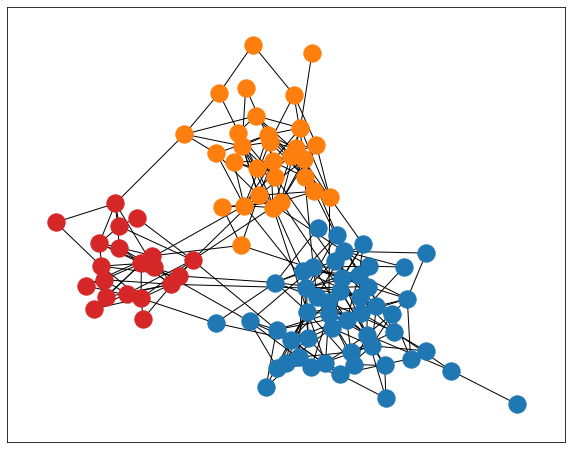

In [292]:
plt.rcParams["figure.figsize"] = (10,8)

sizes = [20, 50, 30]
probs = [[0.25,0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 1/6]]
G = nx.stochastic_block_model(sizes, probs, seed=30)
A = nx.convert_matrix.to_numpy_matrix(G)

pos = nx.spring_layout(G, seed=3113794652)
nx.draw_networkx_nodes(G, pos, nodelist=range(0,sizes[0]), node_color="tab:red")
nx.draw_networkx_nodes(G, pos, nodelist=range(sizes[0], sizes[0]+sizes[1]), node_color="tab:blue")
nx.draw_networkx_nodes(G, pos, nodelist=range(sizes[0]+sizes[1], 100), node_color="tab:orange")
nx.draw_networkx_edges(G, pos)

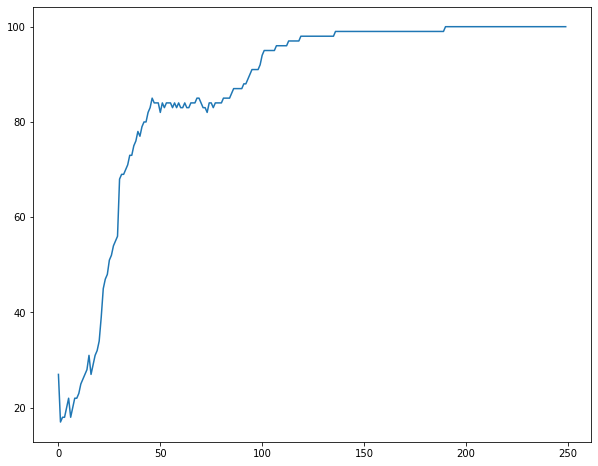

In [300]:
T = Trial(A, 100, 60, 250, 5, 1234567)
T.run()
T.plot_attendance()

In [294]:
T.memory[:, 38]

array([-1, -1,  0, -1,  0, -1,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0,  0, -1,  0,  0, -1,  0,  0, -1, -1, -1, -1,
       -1, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1,  0,  0,  0,  0, -1,  0,
       -1, -1, -1,  0, -1, -1, -1,  0, -1, -1,  0, -1,  0, -1, -1,  0, -1,
       -1,  0,  0, -1, -1,  0, -1, -1,  0,  0, -1, -1, -1, -1,  0,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1])

In [295]:
T.memory[:, 39]

array([-1, -1,  0, -1,  0, -1,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0,  0, -1,  0,  0, -1,  0,  0, -1, -1, -1, -1,
       -1, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1,  0,  0,  0,  0, -1, -1,
       -1, -1, -1,  0, -1, -1, -1,  0, -1, -1,  0, -1,  0, -1, -1,  0, -1,
       -1,  0,  0, -1, -1,  0, -1, -1,  0,  0, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1])

In [296]:
T.best_i[37]

{}

In [297]:
T.best_i[38]

{}

In [277]:
T.best_i[39]

{3: 81, 2: 69, 1: 61}

In [285]:
T.Xnp[:, 38].sum()

60

In [290]:
T.betas[:,35:40]

array([[5, 5, 5, 5, 5],
       [4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 4, 4, 4, 4],
       [5, 5, 5, 5, 5],
       [4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6],
       [5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 6, 6],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5],
       [5, 5, 5,

In [287]:
T.memory[:,35:40]

array([[ 1,  1,  1,  1, -1],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, -1],
       [ 0,  0,  0,  0, -1],
       [ 1,  1,  1,  0, -1],
       [ 1,  1,  1,  1, -1],
       [ 0,  0,  0,  0, -1],
       [ 1,  1,  1,  1, -1],
       [ 0,  0,  0,  0, -1],
       [ 1,  1,  1,  1, -1],
       [ 1,  1,  1,  0,  0],
       [ 1,  1,  1,  1, -1],
       [ 1,  1,  1,  0,  0],
       [ 1,  1,  1,  1, -1],
       [ 0,  0,  0,  0,  0],
       [ 1,  1,  1,  1, -1],
       [ 1,  1,  1,  1, -1],
       [ 1,  1,  1,  1, -1],
       [ 1,  1,  1,  1, -1],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  1,  1, -1],
       [ 1,  1,  1,  1, -1],
       [ 0,  0,  1,  0, -1],
       [ 1,  1,  1,  1, -1],
       [ 0,  0,  0,  0, -1],
       [ 1,  1,  1,  1, -1],
       [ 1,  1,  1,  1, -1],
       [ 0,  0,  0,  0, -1],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 1,  1,  1,  1, -1],
       [ 0,  0,  0,  0,  0],
       [ 0,  0

In [274]:
T.memory[61,35:40]

array([0, 0, 0, 0, 0])

In [261]:
T.memory.mean(axis=0)

array([ 0.  ,  0.08,  0.1 ,  0.11,  0.11,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
        0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.12,  0.14,  0.13,
        0.12,  0.11,  0.1 ,  0.11,  0.11,  0.11,  0.13,  0.14,  0.16,
        0.2 ,  0.21,  0.22,  0.27,  0.28,  0.3 ,  0.3 ,  0.32,  0.33,
        0.41, -0.66, -0.67, -0.7 , -0.71, -0.71, -0.71, -0.71, -0.71,
       -0.73, -0.72, -0.73, -0.72, -0.74, -0.76, -0.77, -0.78, -0.78,
       -0.79, -0.8 , -0.81, -0.81, -0.81, -0.82, -0.83, -0.83, -0.83,
       -0.83, -0.84, -0.83, -0.83, -0.85, -0.86, -0.86, -0.86, -0.87,
       -0.86, -0.87, -0.87, -0.88, -0.88, -0.89, -0.9 , -0.9 , -0.9 ,
       -0.9 , -0.9 , -0.89, -0.9 , -0.89, -0.89, -0.89, -0.89, -0.9 ,
       -0.9 , -0.9 , -0.9 , -0.9 , -0.9 , -0.9 , -0.9 , -0.9 , -0.9 ,
       -0.9 , -0.9 , -0.9 , -0.9 , -0.9 , -0.91, -0.91, -0.91, -0.91,
       -0.93, -0.92, -0.92, -0.93, -0.92, -0.92, -0.92, -0.93, -0.92,
       -0.93, -0.93, -0.93, -0.93, -0.93, -0.93, -0.93, -0.95, -0.95,
       -0.95, -0.95,

In [181]:
T.Xnp[15,:]

array([ True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [136]:
alphas = np.ones(100)
alphas[30:] += 1

alphas

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [71]:
best_i = dict()
best_scores = dict()

order = np.arange(100)
rng.shuffle(order)

for i in order:
    if scores[i] > best_scores.get(K[i], -1):
        best_scores[K[i]] = scores[i]
        best_i[K[i]] = i

In [182]:
scores

array([1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [75]:
for k in np.unique(K):
    changers = np.where(np.bitwise_and(K == k, scores<= 0 ))[0]
    T.alphas[changers, :] = 

In [80]:
k = 4
np.where(np.bitwise_and(K == k, scores<= 0 ))[0]

array([20, 45, 49, 51, 54, 63, 76, 83, 87, 92])

In [83]:
np.bitwise_and(T.Xnp[:,0],T.Xnp[:,10], T.Xnp[:,100])

array([False, False,  True, False, False, False,  True, False,  True,
       False, False,  True,  True, False,  True,  True,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

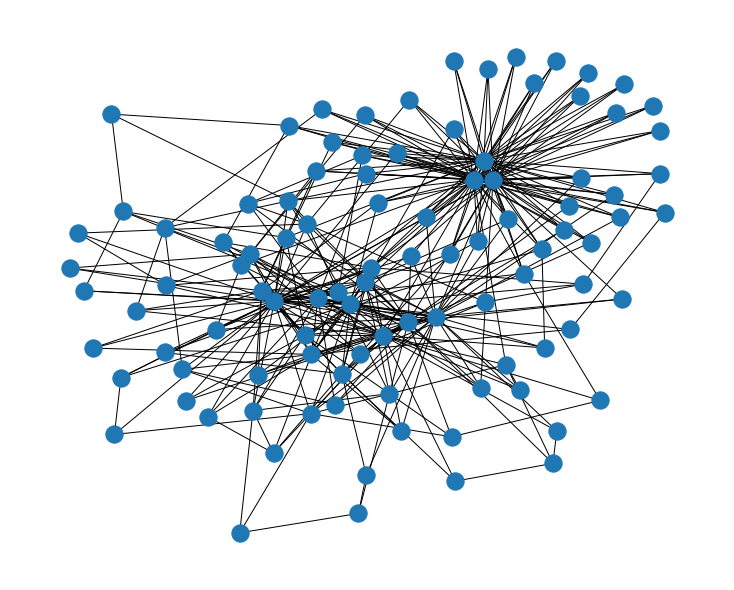

In [252]:
# TODO: configuration model
def truncated_power_law(gamma, k_0, n, size=None):
    """
    Generate a sample of size *size* from a power law distribution
    with mininmum *k_0*, maximum *n*, and power *gamma*
    """
    k_0=np.float64(k_0)
    gamma=np.float64(gamma)
    n=np.float64(n)
    
    if size:
        U = rng.uniform(size=size)
    else:
        U = rng.uniform()
        
    return (
        (k_0**(1-gamma) - 
             ( k_0**(1-gamma) - n**(1-gamma) ) * U 
        )**(1/(1-gamma))
    )

def generate_chung_lu(k):
    n = len(k)

    k_mean = k.mean()
    # k_mean times is twice the expected number of edges
    # this will be the denominator of all edge probabilities
    m2 = k_mean * n

    # initialize adjacency matrix
    A = np.zeros((n,n),dtype=int)
    choices = rng.random(n*(n-1) // 2)
    choice_i = 0
    
    for i in range(n):
        for j in range(i+1,n):
            # no self loops
            if i == j:
                continue
                
            # compute probability of edge
            p = min(
                (k[i] * k[j] / m2,
                1))
            
            # generate edge
            if choices[choice_i] < p:
                A[i,j] = 1
                A[j,i] = 1
            
            choice_i += 1
                
    return A

rng = np.random.default_rng(2357111)

gamma = 2.4
k_0 = 2
n = 100
size=100

k = truncated_power_law(gamma, k_0, n, size=size).astype(int)
k.sort()

A = generate_chung_lu(k)
A.sum(axis=1).mean()

k = A.sum(axis=0)
disco = np.where(k<3)

for i in disco:
    for j in rng.choice(n, size=3):
        A[i,j] = 1
        A[j,i] = 1

G = nx.convert_matrix.from_numpy_array(A)
pos = nx.spring_layout(G, seed=3113794652)

nx.draw(G,pos)

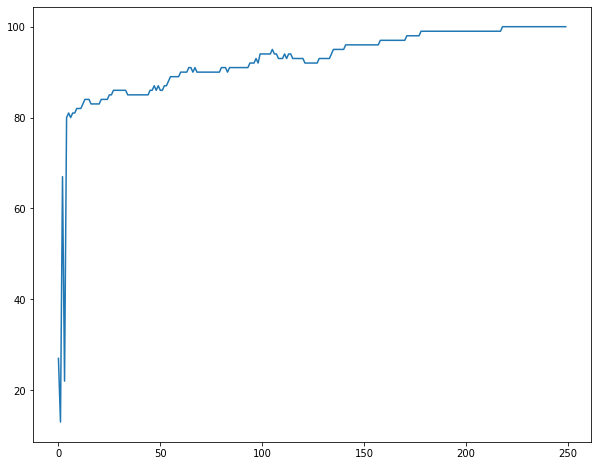

In [253]:
T = Trial(A, 100, 60, 250, 10, 1234567)
T.run()
T.plot_attendance()

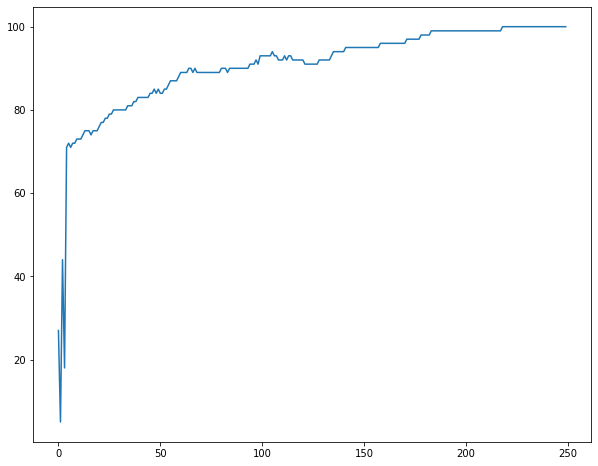

In [254]:
T = Trial(A, 100, 20, 250, 10, 1234567)
T.run()
T.plot_attendance()

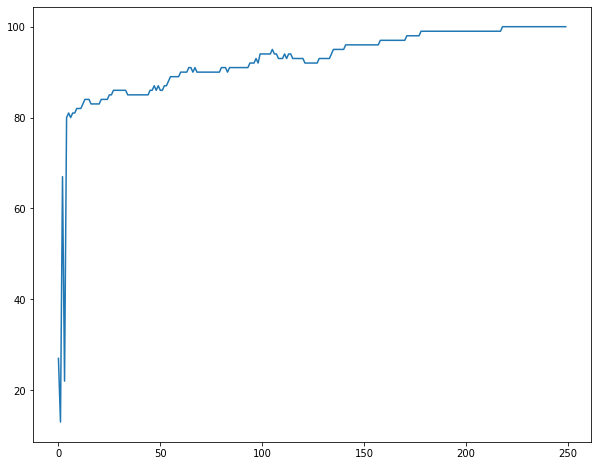

In [255]:
T = Trial(A, 100, 30, 250, 10, 1234567)
T.run()
T.plot_attendance()

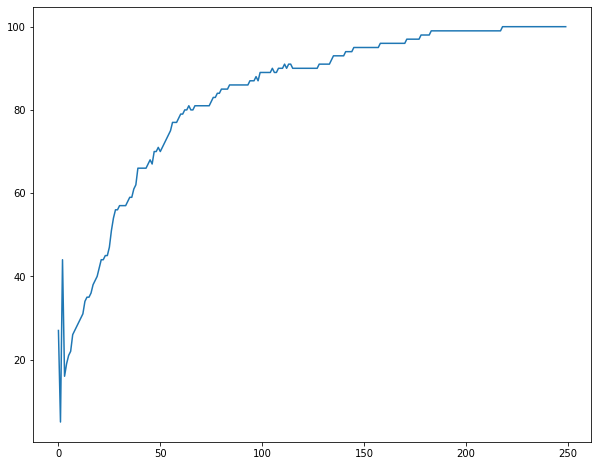

In [256]:
T = Trial(A, 100, 10, 250, 10, 1234567)
T.run()
T.plot_attendance()